# Setting

In [7]:
!pip install torch_geometric

In [8]:
!pip install livelossplot

In [9]:
!pip install netCDF4

In [10]:
!pip install pytorch_msssim torchmetrics


> Imports



In [11]:
import os
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve

from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

from copy import deepcopy


> Connect to Google drive


In [12]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/')
os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive'

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# print(torch.cuda.get_device_name(0))

Using device: cuda


In [14]:
# PyTorch Geometric format
all_features_flat = np.load('JULES/GCN_LSTM_Paper/dataset/train_data_landed_v2.npy')
test_joint_data = np.load('JULES/GCN_LSTM_Paper/dataset/test_joint_data_landed_v2.npy')

In [15]:
all_features_flat = all_features_flat
test_joint_data = test_joint_data
train_data = all_features_flat[:1080,:,:]
validation_data = all_features_flat[1080:,:,:]

In [16]:
print(train_data.shape)
print(train_data.shape)
print(validation_data.shape)
print(train_data.shape[1])
print(train_data.shape[2])

(1080, 7771, 5)
(1080, 7771, 5)
(360, 7771, 5)
7771
5


In [17]:
num_timesteps = 12

from torch.utils.data import Dataset, DataLoader

class MultiStepForecastDataset(Dataset):
    def __init__(self, data, input_steps=12, output_steps=12):
        self.data = data
        self.input_steps = input_steps
        self.output_steps = output_steps

    def __len__(self):
        return self.data.shape[0] - (self.input_steps + self.output_steps) + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.input_steps, :, :]
        y = self.data[idx+self.input_steps:idx+self.input_steps+self.output_steps, :, 0:1]
        return x, y

# Create the custom dataset and dataloader
input_steps = num_timesteps
output_steps = num_timesteps
batch_size = 12

# Create the custom dataset and dataloader for each split
train_dataset = MultiStepForecastDataset(train_data, input_steps, output_steps)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = MultiStepForecastDataset(validation_data, input_steps, output_steps)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for x_batch, y_batch in train_dataloader:
  print(x_batch.shape)
  print(y_batch.shape)
  break

torch.Size([12, 12, 7771, 5])
torch.Size([12, 12, 7771, 1])


In [19]:
graph_data = torch.load('JULES/GCN_LSTM_Paper/dataset/ver_sparse_graph_data_v6.pt')
this_edge_index = graph_data['edge_index']
this_edge_weight = graph_data['edge_weight']
print(this_edge_index.shape)
print(this_edge_weight.shape)
print(this_edge_weight)

torch.Size([2, 2432830])
torch.Size([2432830])
tensor([0.6501, 0.8787, 0.8539,  ..., 0.6040, 0.6359, 0.5310])


In [20]:
this_edge_index = this_edge_index.to(device)
this_edge_weight = this_edge_weight.to(device)

In [21]:
class GCN_LSTM(nn.Module):
    def __init__(self, n_steps_in, n_steps_out, num_nodes, n_features):
        super(GCN_LSTM, self).__init__()

        self.gcn1 = GCNConv(n_features, 1)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.3)

        self.lstm1 = nn.LSTM(input_size=num_nodes, hidden_size=64, batch_first=True)
        self.relu1 = nn.ReLU()

        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.relu2 = nn.ReLU()

        self.dense1 = nn.Linear(64, 256)
        self.relu3 = nn.ReLU()

        self.dense2 = nn.Linear(256, num_nodes)
        self.relu4 = nn.ReLU()

        self.n_steps_out = n_steps_out
        self.num_nodes = num_nodes
        self.n_features = n_features

    def forward(self, x):
        gcn_outputs = []
        for t in range(x.shape[1]):
        # GCN layer, pass each time step's node feature matrix through GCN
            xi = x[:, t]
            xi = self.gcn1(xi, this_edge_index, this_edge_weight)
            xi = self.leaky_relu1(xi)
            gcn_outputs.append(xi)

        x = torch.stack(gcn_outputs, dim=1)

        x = x.view(-1, x.shape[1], self.num_nodes)  # Adjusting the flattening operation

        x, _ = self.lstm1(x)
        x = self.relu1(x)

        x, _ = self.lstm2(x)
        x = self.relu2(x)

        x = self.dense1(x)
        x = self.relu3(x)

        x = self.dense2(x)
        x = self.relu4(x)

        x = x.view(-1, self.n_steps_out, self.num_nodes, 1)  # Reshape to original dimensions

        return x


num_nodes = all_features_flat.shape[1]
num_features = all_features_flat.shape[2]
learning_rate = 0.001
epochs = 1000

# Create model, loss function, and optimiser
model = GCN_LSTM(num_timesteps, num_timesteps, num_nodes, num_features).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
GCN_LSTM(num_timesteps, num_timesteps, num_nodes, num_features)

GCN_LSTM(
  (gcn1): GCNConv(5, 1)
  (leaky_relu1): LeakyReLU(negative_slope=0.3)
  (lstm1): LSTM(7771, 64, batch_first=True)
  (relu1): ReLU()
  (lstm2): LSTM(64, 64, batch_first=True)
  (relu2): ReLU()
  (dense1): Linear(in_features=64, out_features=256, bias=True)
  (relu3): ReLU()
  (dense2): Linear(in_features=256, out_features=7771, bias=True)
  (relu4): ReLU()
)

Epoch 0 Train RMSE: 0.011654, Validation RMSE: 0.008408
Epoch 1 Train RMSE: 0.007169, Validation RMSE: 0.006539
Epoch 2 Train RMSE: 0.006343, Validation RMSE: 0.006296
Epoch 3 Train RMSE: 0.006215, Validation RMSE: 0.006205
Epoch 4 Train RMSE: 0.006171, Validation RMSE: 0.006194
Epoch 5 Train RMSE: 0.006143, Validation RMSE: 0.006131
Epoch 6 Train RMSE: 0.006088, Validation RMSE: 0.006103
Epoch 7 Train RMSE: 0.006051, Validation RMSE: 0.006016
Epoch 8 Train RMSE: 0.005968, Validation RMSE: 0.005960
Epoch 9 Train RMSE: 0.005850, Validation RMSE: 0.005822
Epoch 10 Train RMSE: 0.005650, Validation RMSE: 0.005613
Epoch 11 Train RMSE: 0.005501, Validation RMSE: 0.005449
Epoch 12 Train RMSE: 0.005280, Validation RMSE: 0.005184
Epoch 13 Train RMSE: 0.005024, Validation RMSE: 0.004934
Epoch 14 Train RMSE: 0.004792, Validation RMSE: 0.004741
Epoch 15 Train RMSE: 0.004539, Validation RMSE: 0.004465
Epoch 16 Train RMSE: 0.004294, Validation RMSE: 0.004225
Epoch 17 Train RMSE: 0.004026, Validation

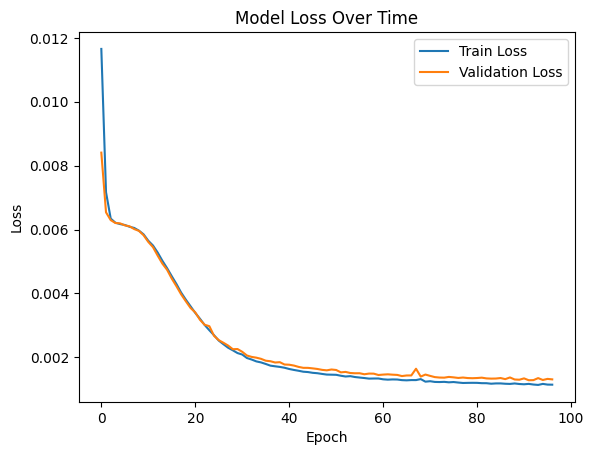

In [ ]:
model.train()
train_losses = []
validation_losses = []

# setup early stopping
early_stopping_counter = 0
patience = 5  # Number of epochs to wait before stopping
best_validation_loss = float('inf')  # best validation loss

for epoch in range(epochs):
    step = 0
    train_loss_list = []
    validation_loss_list = []

    for x_batch, y_batch in train_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(x_batch)

        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

        step= step + 1
        train_loss_list.append(loss.item())

    # switch model to evaluation mode to perform validation
    model.eval()
    with torch.no_grad():
        for x_val, y_val in validation_dataloader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_predictions = model(x_val)
            val_loss = criterion(val_predictions, y_val)
            validation_loss_list.append(val_loss.item())
    model.train()  # switch model back to train mode

    train_epoch_loss = sum(train_loss_list)/len(train_loss_list)
    train_losses.append(train_epoch_loss)

    validation_epoch_loss = sum(validation_loss_list)/len(validation_loss_list)
    validation_losses.append(validation_epoch_loss)

    print("Epoch {} Train MSE: {:.6f}, Validation MSE: {:.6f}".format(epoch, train_epoch_loss, validation_epoch_loss))

    # # Save the model every 10 epochs
    # if epoch % 100 == 0 and epoch > 0:
    #     torch.save(model.state_dict(), "JULES/July/model_states/v21_model_epoch_{}.pth".format(epoch))

    # check for early stopping
    if validation_epoch_loss < best_validation_loss:
        best_validation_loss = validation_epoch_loss
        best_model_weights = deepcopy(model.state_dict())
        early_stopping_counter = 0  # reset the counter
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping at epoch: ", epoch)
            break

plt.figure()

plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')

plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the final model and the best model weights
torch.save(best_model_weights, "JULES/GCN_LSTM/model_states/v21_best_model_weights.pth")

In [ ]:
test_features_flat = test_joint_data.reshape(test_joint_data.shape[0],-1, test_joint_data.shape[-1])  # (time_steps, num_nodes, 5)
test_features_torch = torch.tensor(test_features_flat, dtype=torch.float32)

In [ ]:
test_features_flat.shape

(360, 7771, 5)

In [ ]:
def iterative_forecast(model, initial_data, num_forecasts, device):
    model.eval()

    forecasted_data = []
    input_data = initial_data.to(device)
    # input_data = initial_data

    with torch.no_grad():
        for i in range(num_forecasts):
            # input_data = input_data.squeeze(-1)
            output = model(input_data)

            forecasted_data.append(output.cpu().numpy())

            weather_now = rest_true[i].unsqueeze(0)[:,:,:,1:5].to(device)
            # Prepare the input for the next iteration: use the model's output as the new input
            input_data = torch.cat((output, weather_now), dim=3)

    return np.stack(forecasted_data, axis=0)

# Get the initial 12 time steps from the test dataset
initial_test_data = test_features_torch.data[:num_timesteps]

initial_test_data= initial_test_data.unsqueeze(0)

print(initial_test_data.shape)

# Forecast the next 29 years
num_forecasts = 29

rest_true = test_features_torch[num_timesteps:]
rest_true = rest_true.reshape(num_forecasts,num_timesteps,num_nodes,num_features)
print(rest_true.shape)

forecasted_data = iterative_forecast(model, initial_test_data, num_forecasts, device)
print(forecasted_data.shape)

torch.Size([1, 12, 7771, 5])
torch.Size([29, 12, 7771, 5])
(29, 1, 12, 7771, 1)


In [ ]:
import netCDF4 as nc
import numpy as np

# Open the netCDF file
nc_file = nc.Dataset('JULES/CRU-NCEPv7.landfrac.nc', mode='r')

print('Variable Names:')
for var_name in nc_file.variables:
    var = nc_file.variables[var_name]
    print(var_name, var.shape)

print('\nDimension Names and Sizes:')
for dim_name in nc_file.dimensions:
    dim = nc_file.dimensions[dim_name]
    print(dim_name, len(dim))

var = nc_file.variables['field36'][27:-5,:]

# Close the netCDF file
nc_file.close()

land_mask = np.array(var)

print(land_mask.shape)

Variable Names:
longitude (192,)
latitude (144,)
field36 (144, 192)

Dimension Names and Sizes:
longitude 192
latitude 144
(112, 192)


In [ ]:
# Mapping back to original shape
def decompress_data(compressed_data, land_mask):
    timesteps, _, num_features = compressed_data.shape
    decompressed_data = np.zeros((timesteps, land_mask.size, num_features))
    decompressed_data[:, land_mask.flatten()> 0, :] = compressed_data
    return decompressed_data.reshape(timesteps, land_mask.shape[0], land_mask.shape[1], num_features)

gcn_lstm_forecasted_data = np.reshape(forecasted_data, (-1, 7771, 1))

decompressed_gcn_lstm = decompress_data(gcn_lstm_forecasted_data, land_mask)
gcn_lstm_forecasted = np.squeeze(decompressed_gcn_lstm)
print(gcn_lstm_forecasted.shape)

gcn_lstm_forecasted = gcn_lstm_forecasted.reshape(29, 12, 112, 192, 1)
print(gcn_lstm_forecasted.shape)

decompressed_rest_true = np.reshape(rest_true, (-1, 7771, 5))
decompressed_rest_true = decompressed_rest_true[:, :, 0:1]

decompressed_rest_true = decompress_data(decompressed_rest_true, land_mask)
decompressed_rest_true = np.squeeze(decompressed_rest_true)

decompressed_rest_true = decompressed_rest_true.reshape(29, 12, 112, 192, 1)
print(decompressed_rest_true.shape)

(348, 112, 192)
(29, 12, 112, 192, 1)
(29, 12, 112, 192, 1)


In [ ]:
def mse(true_data, forecasted_data):
    true_data_flatten = true_data.flatten()
    forecasted_data_flatten = forecasted_data.flatten()
    return mean_squared_error(true_data_flatten, forecasted_data_flatten)

def rrmse(true_data, forecasted_data):
    true_data_flatten = true_data.flatten()
    forecasted_data_flatten = forecasted_data.flatten()
    return np.sqrt(mean_squared_error(true_data_flatten, forecasted_data_flatten)) / true_data_flatten.std()

def calc_ssim(true_data, forecasted_data):
    ssim_list = []
    for i in range(true_data.shape[0]): # iterate over big steps
        ssim_val = 0
        for j in range(true_data.shape[1]): # iterate over sub steps
            true_data_2d = true_data[i,j,:,:,0].reshape(true_data.shape[2], true_data.shape[3])
            forecasted_data_2d = forecasted_data[i,j,:,:,0].reshape(forecasted_data.shape[2], forecasted_data.shape[3])
            ssim_val += ssim(true_data_2d, forecasted_data_2d, data_range=forecasted_data_2d.max() - forecasted_data_2d.min())
        ssim_list.append(ssim_val / true_data.shape[1]) # average SSIM over all sub steps
    return ssim_list

def calc_psnr(true_data, forecasted_data):
    psnr_list = []
    for i in range(true_data.shape[0]): # iterate over big steps
        psnr_val = 0
        for j in range(true_data.shape[1]): # iterate over sub steps
            true_data_2d = true_data[i,j,:,:,0].reshape(true_data.shape[2], true_data.shape[3])
            forecasted_data_2d = forecasted_data[i,j,:,:,0].reshape(forecasted_data.shape[2], forecasted_data.shape[3])
            psnr_val += psnr(true_data_2d, forecasted_data_2d, data_range=forecasted_data_2d.max() - forecasted_data_2d.min())
        psnr_list.append(psnr_val / true_data.shape[1]) # average PSNR over all sub steps
    return psnr_list

def calc_loss(true_data, forecasted_data):
    mse_list, rrmse_list = [], []
    for i in range(forecasted_data.shape[0]):
        mse_list.append(mse(true_data[i], forecasted_data[i]))
        rrmse_list.append(rrmse(true_data[i], forecasted_data[i]))
    ssim_list = calc_ssim(true_data, forecasted_data)
    psnr_list = calc_psnr(true_data, forecasted_data)
    return mse_list, rrmse_list, ssim_list, psnr_list

gcn_lstm_losses = calc_loss(decompressed_rest_true, gcn_lstm_forecasted)

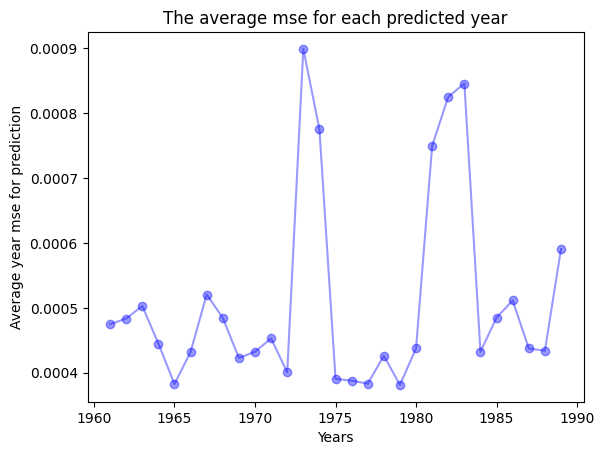

0.0005113322103882485
0.2922958879171365
0.9665220197706408
33.285511702237436


In [ ]:
x = list(range(1960+1, 1960+num_forecasts+1))
plt.plot(x, gcn_lstm_losses[0],'bo-', alpha=0.4)
plt.title("The average mse for each predicted year")
plt.xlabel("Years")
plt.ylabel("Average year mse for prediction")
plt.show()

print(np.mean(gcn_lstm_losses[0]))
print(np.mean(gcn_lstm_losses[1]))
print(np.mean(gcn_lstm_losses[2]))
print(np.mean(gcn_lstm_losses[3]))